In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bbc-full-text-document-classification/bbc_data.csv


In [2]:
df = pd.read_csv('/kaggle/input/bbc-full-text-document-classification/bbc_data.csv')
df.head()

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


In [3]:
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from category_encoders import OneHotEncoder

%matplotlib inline

In [4]:

df.loc[0,'data']

'Musicians to tackle US red tape  Musicians groups are to tackle US visa regulations which are blamed for hindering British acts chances of succeeding across the Atlantic.  A singer hoping to perform in the US can expect to pay $1,300 (xc2xa3680) simply for obtaining a visa. Groups including the Musicians Union are calling for an end to the "raw deal" faced by British performers. US acts are not faced with comparable expense and bureaucracy when visiting the UK for promotional purposes.  Nigel McCune from the Musicians Union said British musicians are "disadvantaged" compared to their US counterparts. A sponsor has to make a petition on their behalf, which is a form amounting to nearly 30 pages, while musicians face tougher regulations than athletes and journalists. "If you make a mistake on your form, you risk a five-year ban and thus the ability to further your career," says Mr McCune.  "The US is the worlds biggest music market, which means something has to be done about the creaky 

In [5]:
df['labels'].unique()

array(['entertainment', 'business', 'sport', 'politics', 'tech'],
      dtype=object)

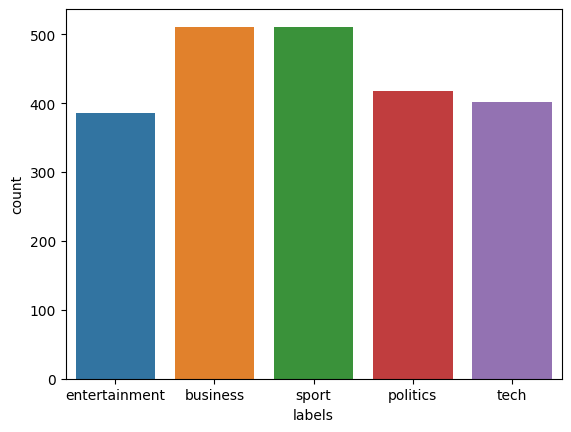

In [6]:
sns.countplot(x = 'labels',data = df)
plt.show()

In [7]:
df["len"] = df['data'].apply(len)



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


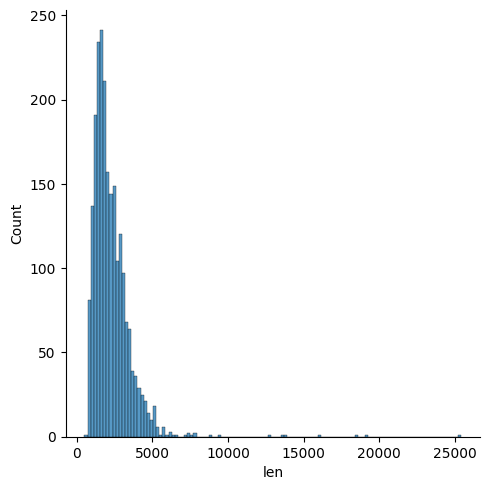

In [8]:
sns.displot(x = 'len', data = df)
plt.show()

In [9]:
df.head()

,data,labels,len
0,Musicians to tackle US red tape Musicians gro...,entertainment,2254
1,"U2s desire to be number one U2, who have won ...",entertainment,4799
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment,2125
3,Snicket tops US box office chart The film ada...,entertainment,1052
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment,1598


In [10]:
sent_tokenize(df.loc[0,'data'])

['Musicians to tackle US red tape  Musicians groups are to tackle US visa regulations which are blamed for hindering British acts chances of succeeding across the Atlantic.',
 'A singer hoping to perform in the US can expect to pay $1,300 (xc2xa3680) simply for obtaining a visa.',
 'Groups including the Musicians Union are calling for an end to the "raw deal" faced by British performers.',
 'US acts are not faced with comparable expense and bureaucracy when visiting the UK for promotional purposes.',
 'Nigel McCune from the Musicians Union said British musicians are "disadvantaged" compared to their US counterparts.',
 'A sponsor has to make a petition on their behalf, which is a form amounting to nearly 30 pages, while musicians face tougher regulations than athletes and journalists.',
 '"If you make a mistake on your form, you risk a five-year ban and thus the ability to further your career," says Mr McCune.',
 '"The US is the worlds biggest music market, which means something has to

In [11]:
df.loc[0,'data'].lower()

'musicians to tackle us red tape  musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic.  a singer hoping to perform in the us can expect to pay $1,300 (xc2xa3680) simply for obtaining a visa. groups including the musicians union are calling for an end to the "raw deal" faced by british performers. us acts are not faced with comparable expense and bureaucracy when visiting the uk for promotional purposes.  nigel mccune from the musicians union said british musicians are "disadvantaged" compared to their us counterparts. a sponsor has to make a petition on their behalf, which is a form amounting to nearly 30 pages, while musicians face tougher regulations than athletes and journalists. "if you make a mistake on your form, you risk a five-year ban and thus the ability to further your career," says mr mccune.  "the us is the worlds biggest music market, which means something has to be done about the creaky 

In [12]:
data = list(df['data'])

In [13]:
data_lower = [a.lower() for a in data]

In [14]:
tokens = [word_tokenize(a) for a in data_lower]

In [15]:
sw = stopwords.words('english')
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

## **Stopwords Removal**

In [16]:
tokens = [[w for w in t if w not in sw] for t in tokens]

In [17]:
print(tokens[:1])

[['musicians', 'tackle', 'us', 'red', 'tape', 'musicians', 'groups', 'tackle', 'us', 'visa', 'regulations', 'blamed', 'hindering', 'british', 'acts', 'chances', 'succeeding', 'across', 'atlantic', '.', 'singer', 'hoping', 'perform', 'us', 'expect', 'pay', '$', '1,300', '(', 'xc2xa3680', ')', 'simply', 'obtaining', 'visa', '.', 'groups', 'including', 'musicians', 'union', 'calling', 'end', '``', 'raw', 'deal', "''", 'faced', 'british', 'performers', '.', 'us', 'acts', 'faced', 'comparable', 'expense', 'bureaucracy', 'visiting', 'uk', 'promotional', 'purposes', '.', 'nigel', 'mccune', 'musicians', 'union', 'said', 'british', 'musicians', '``', 'disadvantaged', "''", 'compared', 'us', 'counterparts', '.', 'sponsor', 'make', 'petition', 'behalf', ',', 'form', 'amounting', 'nearly', '30', 'pages', ',', 'musicians', 'face', 'tougher', 'regulations', 'athletes', 'journalists', '.', '``', 'make', 'mistake', 'form', ',', 'risk', 'five-year', 'ban', 'thus', 'ability', 'career', ',', "''", 'says'

In [18]:
if 'us' in sw:
    print("'us' is a stopword.")
else:
    print("'us' is not a stopword.")

'us' is not a stopword.


## **Remove Punctuations**

In [19]:
punc = RegexpTokenizer(r'\w+')

In [20]:
tokens = [["".join(punc.tokenize(word)) for word in t if len(punc.tokenize(word)) > 0] for t in tokens]

In [21]:
import re

def remove_punc(text) :
    return re.sub(r'[^\w\s.,\'"]','',text)

check = [text for text in tokens]


In [22]:
print(tokens[:1])

[['musicians', 'tackle', 'us', 'red', 'tape', 'musicians', 'groups', 'tackle', 'us', 'visa', 'regulations', 'blamed', 'hindering', 'british', 'acts', 'chances', 'succeeding', 'across', 'atlantic', 'singer', 'hoping', 'perform', 'us', 'expect', 'pay', '1300', 'xc2xa3680', 'simply', 'obtaining', 'visa', 'groups', 'including', 'musicians', 'union', 'calling', 'end', 'raw', 'deal', 'faced', 'british', 'performers', 'us', 'acts', 'faced', 'comparable', 'expense', 'bureaucracy', 'visiting', 'uk', 'promotional', 'purposes', 'nigel', 'mccune', 'musicians', 'union', 'said', 'british', 'musicians', 'disadvantaged', 'compared', 'us', 'counterparts', 'sponsor', 'make', 'petition', 'behalf', 'form', 'amounting', 'nearly', '30', 'pages', 'musicians', 'face', 'tougher', 'regulations', 'athletes', 'journalists', 'make', 'mistake', 'form', 'risk', 'fiveyear', 'ban', 'thus', 'ability', 'career', 'says', 'mr', 'mccune', 'us', 'worlds', 'biggest', 'music', 'market', 'means', 'something', 'done', 'creaky',

## **Stemming**

In [23]:
porter = PorterStemmer()
lancaster = LancasterStemmer()

In [24]:
tokens = [[lancaster.stem(word) for word in t] for t in tokens]

In [25]:
clean_tokens = [" ".join(t) for t in tokens]

In [26]:
print(clean_tokens[:1])

['mus tackl us red tap mus group tackl us vis reg blam hind brit act chant success across atl sing hop perform us expect pay 1300 xc2xa3680 simply obtain vis group includ mus un cal end raw deal fac brit perform us act fac comp expens bureaucr visit uk promot purpos nigel mccune mus un said brit mus disadv comp us counterpart spons mak petit behalf form amount near 30 pag mus fac tough reg athlet journ mak mistak form risk fiveyear ban thu abl car say mr mccune us world biggest mus market mean someth don creaky bureaucr say mr mccune cur situ prev brit act maintain moment develop us ad mus un stant endors mus man for mmf say brit art fac uphil struggle success us thank tough vis requir also seen impract mmfs gen secret jam sel said imagin orchestr orkney every memb would travel london visa process us market seen holy grail on benchmark success stil going fight get stil import market lik europ ind chin ad mr sel depart med cult sport spokeswom said aw peopl expery problem work us embass

## **Bag of Words**

In [27]:
vect = CountVectorizer(binary = False, min_df = 5)
#binary parameter decides if the counts will be binary for the Vectorizer
#min_df sets the threshols for the minimum number of occurence for a word to be vectorized

In [28]:
X = vect.fit_transform(clean_tokens)

In [29]:
X = X.toarray()

In [30]:
df.loc[1409,'data']

'Donor attacks Blair-Brown feud  The reported feud between Tony Blair and Gordon Brown has prompted a Labour donor to say he will almost certainly refuse to give more funds.  Duncan Bannatyne also attacked the government over Iraq and its "poor" response to the Asian tsunami crisis. His broadside came as ex-Foreign Secretary Robin Cook said he hoped Mr Brown would be premier at some point. Mr Bannatyne has previously given Labour xc2xa350,000. He made his fortune from care homes and health clubs.  The 52-year-old on Tuesday said was he was reviewing his donations because of Cabinet disunity and international issues. His spokesman said it was highly unlikely he would give Labour more money, although he would remain a supporter and not fund the Conservatives.  Robert Pestons new book has prompted more speculation about the Blair-Brown rift with its claims that the prime minister broke a promise made in 2003 to stand down. Mr Bannatyne said: "Disunity in the Cabinet has a corrosive effect

In [31]:
df.loc[df['labels'] == 'politics'].head()

,data,labels,len
1407,Baron Kinnock makes Lords debut Former Labour...,politics,2499
1408,Howard taunts Blair over splits Tony Blairs f...,politics,2885
1409,Donor attacks Blair-Brown feud The reported f...,politics,2775
1410,Cardinal criticises Iraq war cost Billions of...,politics,2497
1411,BNP leader Nick Griffin arrested The leader o...,politics,1268


In [32]:
ohe = OneHotEncoder(use_cat_names = True)
y = ohe.fit_transform(df['labels'])

In [33]:
y = df['labels']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.2)

In [35]:
X_train[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [36]:
log_model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter = 1000)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [37]:
test_pred = log_model.predict(X_test)

accuracy = accuracy_score(y_test, test_pred)

print(accuracy)

0.9842696629213483


In [38]:
train_pred = log_model.predict(X_train)

train_accuracy = accuracy_score(y_train, train_pred)

print(train_accuracy)

1.0


## **TF-IDF Vectorizer**

In [39]:
tfidf_vect = TfidfVectorizer(min_df = 5)

In [40]:
X = tfidf_vect.fit_transform(clean_tokens)

In [41]:
y.unique()

array(['entertainment', 'business', 'sport', 'politics', 'tech'],
      dtype=object)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [43]:
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [44]:
test_pred = log_model.predict(X_test)


In [45]:
punc.tokenize('[adhiun;;l[pqo0902]')

['adhiun', 'l', 'pqo0902']

In [46]:
accuracy = accuracy_score(y_test, test_pred)
print(accuracy)

0.9865168539325843


In [47]:
def label_model(data) : 
    #x = list(data)
    #lower case
    data = data.lower()
    #tokenize the words
    tokens = word_tokenize(data)
    #stopwords removal
    tokens = [w for w in tokens if w not in sw]
    #punctutation removal
    #tokens = ["".join(punc.tokenize(word)) for word in tokens if len(punc.tokenize(word)) > 0]
    tokens = " ".join(tokens)
    tokens = punc.tokenize(tokens)
    stemmed_tokens = [porter.stem(word) for word in tokens]
    #tokens = [lancaster.stem(t) for t in tokens]
    #joining back the words
    clean_tokens = " ".join(stemmed_tokens)
    return clean_tokens

def machine_model(x) :
    X = [label_model(x)]
    tfidf = tfidf_vect.transform(X)
    label = log_model.predict(tfidf)
    return label
    

In [48]:
machine_model("An Israeli airstrike on a house in Gaza’s southernmost city killed at least nine people, six of them children, hospital authorities said Saturday, as Israel pursued its nearly seven-month offensive in the besieged Palestinian territory.Israel’s war against the Islamic militant group Hamas has led to a dramatic escalation of tensions in an already volatile Middle East. The strike late Friday hit a residential building in the western Tel Sultan neighborhood of the city of Rafah, according to Gaza’s civil defense. The bodies of the six children, two women and a man were taken to Rafah’s Abu Yousef al-Najjar hospital, the hospital’s records showed. At the hospital, relatives cried and hugged the bodies of the children, wrapped in white shrouds, as others comforted them.")


array(['sport'], dtype=object)